<a href="https://colab.research.google.com/github/mk-ctrl/project-customs/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sympy import symbols, And, Or

# **Sample Dataset**

In [ ]:
data = {
    'product_type': ['electronics'] * 10 + ['clothing'] * 10 + ['furniture'] * 10,
    'origin_country': ['China', 'USA', 'China', 'Germany', 'China', 'USA', 'India', 'Vietnam', 'Japan', 'Korea'] * 3,
    'destination_country': ['USA', 'China', 'Germany', 'USA', 'Germany', 'USA', 'USA', 'China', 'Japan', 'Korea'] * 3,
    'value': [500, 700, 200, 300, 800, 450, 150, 600, 350, 900] * 3,
    'risk_level': [1, 2, 1, 0, 2, 1, 0, 2, 1, 2] * 3
}

df = pd.DataFrame(data)
print(f'Dataset: {df}')



Dataset:    product_type origin_country destination_country  value  risk_level
0   electronics          China                 USA    500           1
1   electronics            USA               China    700           2
2   electronics          China             Germany    200           1
3   electronics        Germany                 USA    300           0
4   electronics          China             Germany    800           2
5   electronics            USA                 USA    450           1
6   electronics          India                 USA    150           0
7   electronics        Vietnam               China    600           2
8   electronics          Japan               Japan    350           1
9   electronics          Korea               Korea    900           2
10     clothing          China                 USA    500           1
11     clothing            USA               China    700           2
12     clothing          China             Germany    200           1
13     clot

# **Extra Features**
🔹 Summary of Improvements

✅ 1️⃣ Country-Based Risk Scoring


*   Instead of treating only China as high-risk, we assigned risk scores (1-3) to
all countries based on past fraud trends.



✅ 2️⃣ Product-Specific Risk Levels



*   Some products (like electronics) are more prone to fraud than others (like furniture), so we assigned risk scores to each product type.



✅ 3️⃣ High-Value Shipment Flagging



*   Instead of just categorizing values, we explicitly flagged the top 25% most expensive shipments as high-risk.


✅ 4️⃣ High-Risk + High-Value Combination



*   We identified shipments that are both high-risk (based on origin) and high-value, since they are more likely to be fraudulent.


✅ 5️⃣ Large Shipment Detection



*   Countries that suddenly ship an unusually high number of products might indicate fraud, so we added a feature to detect this pattern.


✅ 6️⃣ Feature Selection Update



*   We replaced simple labels with meaningful risk-based numerical features to help the model learn better.



In [ ]:
# Define country risk levels (1 = Low Risk, 3 = High Risk)
country_risk = {
    'China': 3, 'Vietnam': 2, 'India': 2, 'USA': 1, 'Germany': 1, 'Japan': 1, 'Korea': 1
}

# Assign risk scores
df['origin_risk_score'] = df['origin_country'].map(country_risk)
df['destination_risk_score'] = df['destination_country'].map(country_risk)

# Define product risk levels (1 = Low, 3 = High)
product_risk = {'electronics': 3, 'clothing': 1, 'furniture': 1}

# Apply product risk scores
df['product_risk_score'] = df['product_type'].map(product_risk)

value_threshold = df['value'].quantile(0.75)  # Get the top 25% value threshold

df['is_high_value'] = (df['value'] > value_threshold).astype(int)

df['high_risk_high_value'] = (df['origin_risk_score'] >= 2) & (df['is_high_value'] == 1)
df['high_risk_high_value'] = df['high_risk_high_value'].astype(int)

df['shipment_count'] = df.groupby('origin_country')['origin_country'].transform('count')
df['is_large_shipment'] = (df['shipment_count'] > df['shipment_count'].median()).astype(int)


0     500
1     700
2     200
3     300
4     800
5     450
6     150
7     600
8     350
9     900
10    500
11    700
12    200
13    300
14    800
15    450
16    150
17    600
18    350
19    900
20    500
21    700
22    200
23    300
24    800
25    450
26    150
27    600
28    350
29    900
Name: value, dtype: int64
700.0
0     0
1     0
2     0
3     0
4     1
5     0
6     0
7     0
8     0
9     1
10    0
11    0
12    0
13    0
14    1
15    0
16    0
17    0
18    0
19    1
20    0
21    0
22    0
23    0
24    1
25    0
26    0
27    0
28    0
29    1
Name: is_high_value, dtype: int64


# **Feature Engineering**


1.   Categorizing Features
2.   For values & transport risk



In [ ]:
def create_features(df):
    df['value_category'] = pd.qcut(df['value'], q=5, labels=['VL', 'L', 'M', 'H', 'VH'])
    df['high_risk_route'] = ((df['origin_country'] == 'China') &
                            (df['destination_country'].isin(['USA', 'Germany']))).astype(int)
    return df

df = create_features(df)
print(df)

   product_type origin_country destination_country  value  risk_level  \
0   electronics          China                 USA    500           1   
1   electronics            USA               China    700           2   
2   electronics          China             Germany    200           1   
3   electronics        Germany                 USA    300           0   
4   electronics          China             Germany    800           2   
5   electronics            USA                 USA    450           1   
6   electronics          India                 USA    150           0   
7   electronics        Vietnam               China    600           2   
8   electronics          Japan               Japan    350           1   
9   electronics          Korea               Korea    900           2   
10     clothing          China                 USA    500           1   
11     clothing            USA               China    700           2   
12     clothing          China             Germany 

# **Encoding Categorical data (Text to Numbers)**

In [ ]:
le_dict = {}
categorical_columns = ['product_type', 'origin_country', 'destination_country', 'value_category']

for col in categorical_columns:
    le_dict[col] = LabelEncoder()
    df[f'{col}_encoded'] = le_dict[col].fit_transform(df[col])
print(df.iloc[:,4:])

    risk_level value_category  high_risk  high_risk_route  \
0            1              M          0                1   
1            2              H          1                0   
2            1             VL          0                1   
3            0              L          0                0   
4            2             VH          1                1   
5            1              M          0                0   
6            0             VL          0                0   
7            2              H          1                0   
8            1              L          0                0   
9            2             VH          1                0   
10           1              M          0                1   
11           2              H          1                0   
12           1             VL          0                1   
13           0              L          0                0   
14           2             VH          1                1   
15           1          

# **Preparing Data For ML**

1.   separating features and target
2.   Features : product,country,value,risk,value
     
     Target : risk level



In [ ]:
feature_columns = [
    'origin_risk_score', 'destination_risk_score', 'product_risk_score',
    'is_large_shipment', 'is_high_value', 'high_risk_high_value'
] + list(df.filter(like="product_type_")) + list(df.filter(like="origin_country_")) + list(df.filter(like="destination_country_"))

X = df[feature_columns]  # Updated feature set
y = df['risk_level']  # Target variable


# **Training the Machine Learning Model**
***Creates a model pipeline with:***

1.StandardScaler() → Ensures numeric values are on the same scale.

2.RandomForestClassifier() → A decision-tree-based model that predicts risk levels



> **//XGBClassifier is used since it can be faster with large datasets**

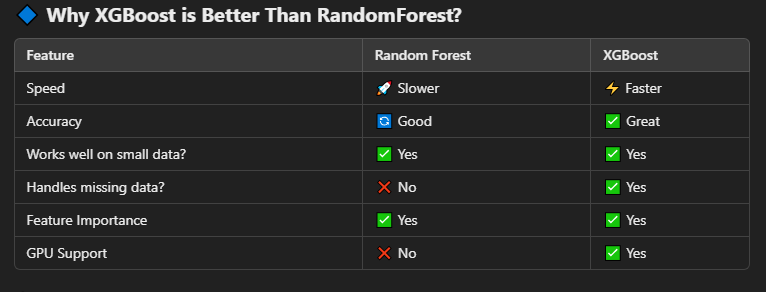



In [ ]:
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=300,    # Number of trees
        learning_rate=0.05,  # How fast the model learns
        max_depth=10,        # Maximum depth of each tree
        subsample=0.8,       # Uses 80% of data per tree (prevents overfitting)
        colsample_bytree=0.8,# Uses 80% of features per tree
        random_state=42
    ))
])
print(pipeline)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,

# **Hyperparameter Tuning (Optimizing the Model)**

1.Tests multiple ML settings to find the best combination.

2.RandomizedSearchCV() : automatically finds the most accurate model.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [5, 10, 15],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9]
}


xgb = XGBClassifier()
random_search = RandomizedSearchCV(xgb, param_grid, n_iter=20, cv=5, n_jobs=-1)
random_search.fit(X, y)
best_model = random_search.best_estimator_


# **Symbolic Rule-Based System (Manual Rules for Risk Detection)**

In [ ]:
def check_compliance(row):
    risk_score = 0

    # Product type rules
    if row['product_type'] == 'electronics':
        if row['value'] > 700:
            risk_score += 3
        elif row['value'] > 500:
            risk_score += 2

    # Country risk rules
    high_risk_countries = ['China']
    medium_risk_countries = ['Vietnam', 'India', 'Korea']

    if row['origin_country'] in high_risk_countries:
        risk_score += 2
    elif row['origin_country'] in medium_risk_countries:
        risk_score += 1

    # Value-based rules
    if row['value'] > 800:
        risk_score += 3
    elif row['value'] > 600:
        risk_score += 2

    # Route-based rules
    if row['high_risk_route'] == 1:
        risk_score += 2

    # Final classification
    return 2 if risk_score >= 5 else (1 if risk_score >= 3 else 0)

df['symbolic_risk'] = df.apply(check_compliance, axis=1)


# **Combining ML & Rule-Based Predictions**

In [ ]:
def combined_risk_assessment(row, model=best_model):
    features = np.array([[row[col] for col in feature_columns]])
    ml_prediction = model.predict(features)[0]  # Get XGBoost prediction
    symbolic_prediction = check_compliance(row)  # Rule-based prediction

    # Weighted combination: XGBoost is preferred if confidence is high
    ml_confidence = max(model.predict_proba(features)[0])

    if ml_confidence > 0.8:
        final_risk = ml_prediction
    elif ml_confidence > 0.5:
        final_risk = int(0.7 * ml_prediction + 0.3 * symbolic_prediction)
    else:
        final_risk = symbolic_prediction

    return final_risk

df['combined_risk'] = df.apply(combined_risk_assessment, axis=1)


# **Evaluating the Model’s Accuracy**

In [ ]:
final_accuracy = accuracy_score(df['risk_level'], df['combined_risk'])
print(f"\nFinal Combined Model Accuracy: {final_accuracy:.2f}")


Final Combined Model Accuracy: 1.00
